In [1]:
#markdown customization
from IPython.display import display, HTML # type:ignore
style = '<style> body { font-family: Cambria Math; font-size: 16px; } </style>'
display(HTML(style))

In [3]:
# major imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# <div style="font-family:fantasy;">Training Deep Neural Networks</div>
For a model with so many parameters will risk overfitting. There are several problems with backpropagation. That are discussed below

# <div style="font-family:fantasy;">Vanishing / Exploding Gradients</div>
The gradients in backpropagation gets smaller and smaller as the algorithm progresses down to the lower layers. As a result Gradient Descent update leaves lower layers connection weights virtually unchanged and training never converges to a good solution. The opposite this state is: the gradients can grow bigger and bigger, so many layers get insanely large weight updates and the algorithm diverges. This is the _exploding gradients_ problem, which is mostly encountered in recurrent neural networks.\
Few suspects in this field are :
* the sigmoid logistic function: this creates the anomally as it saturates for a large value of *x* in both posittive and negative direction. Thus making the gradient $0$
* weight initialization technique: using normal distribution with mean = 0 and standard deviation=1. Thus each layers output variance is much greater than the previous layer's output. The variance keeps on increasing till the activation function saturates.
Thus backpropagation fails out here and  the little gradinet present keeps diluting as the backpropagation proeceds from top layer to down.



In [3]:
#defining sigmoid
def logit(z):
    return 1 / (1 + np.exp(-z))

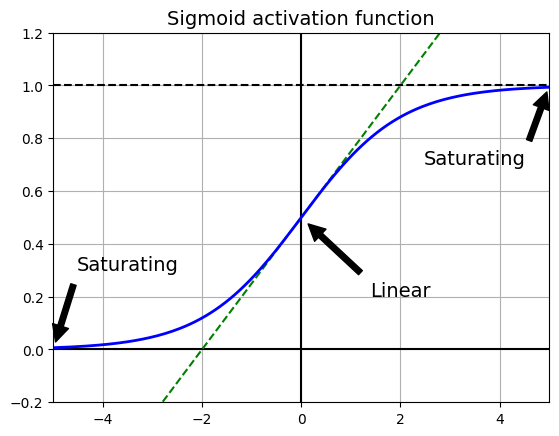

In [4]:
#plotting
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])


plt.show()

### <div style="font-family:fantasy;">Glorot and He intilization</div>
* The variance of outputs of each layer should be equal to that of the previous layer in forward flow
* also the gradients should have equal variance before and after flowing through a layer in the reverse direction. 
It is impossible to guarantee both of them at the same time unless the layer has an equal number of inputs and neurons (these numbers are called the *fan-in* and *fan-out* of the layer). Thus we tweak the weights of the connections. The weights are now randomly initialized with,\
normal distribution with $\mu=0$ and $\sigma = \sqrt{\frac{2}{fan_{in}+fan_{out}}}$
$\mathbf{OR}$, uniform distribution btwn $-r$ and $r$ with $r=\sqrt{\frac{6}{fan_{in}+fan_{out}}}$\
Note that the above if the acivation function used is logistic function.

<img src="https://dsm04pap003files.storage.live.com/y4mvN9LaSohnWht80kht_q5__cgD1YRCIAotHDmTEasOmNqo5ljYpNPW9CUz-EY9eV-hG3M1xwqSKJR1gZwFlTYPwTcr6D63vvOt_SjMgN5MRDspQ8IURLEwSX_KmTMxlCOHsu-4QAEgo-ud8JuyT6DURQBIR2HFGx98kGVQRZrJQ36HOfv_tBnrOCXVllTCDLX?width=413&height=127&cropmode=none" width="413" height="127" />

here $fan_{avg} = \frac{fan_{in}+fan_{out}}{2}$
We can use this to speed up training. We can set the layer to the He initialization by setting the layer as\

    keras.layers.Dense(10,activation='relu',kernel_initializer='he_normal')
    
though we can also use `he_uniform`.\
Also for using fan-avg,


    he_avg_init = keras.initializers.VarianceScaling(scale=2.0,mode='fan_avg',distribution='uniform')
    keras.layers.Dense(10,activation='sogmoid',kernel_initializer='he_avg_init')


### <div style="font-family:fantasy;">Non Saturating Activation function</div>
now we faced the problem of unstable gradients as the sigmoid function saturated to a constant value of both positive and negative thresholds. Thus creating unstable gradients.\
Thus it is important to choose a good activation function.
1. ReLU:

    * This seems to be a good activation function. But even this suffers from neuron killing, i.e. as the training proceeds some neurons continously output 0
    * even with large learning rate a neuron dies when its weights get tweaked such that weighted sum of its inputs are negative for all instance in the training set. Also gradient descent cannot affect it because it's gradient is 0 when input is negative.

2. Leaky ReLU:

    $LeakyReLU_{\alpha}(z) = max(\alpha z,z)$
    $\alpha$ defines how much function leaks. It is actually the slope of the function for $z<0$ and is typically set to 0.01. The small slope ensures that the function do not die. Though they can go on a long break but they will not die. Setting $\alpha=0.2$(huge leak) results in much better performance. 


In [5]:
#defining leaky ReLU
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

(-5.0, 5.0, -0.5, 4.2)

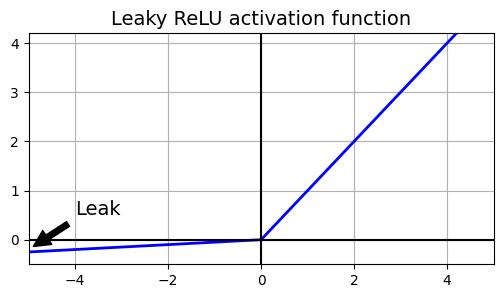

In [6]:
#plotting
plt.figure(figsize=(6, 3))
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])


3. Randomized Leaky ReLU (RReLU):

    * the $\alpha$ is picked up randomly in a given range during training and is fixed to an average value during testing.
    * RReLU seems to act as a regularizer. 
4. parametric leaky ReLU (PReLU):

    * here $\alpha$ is authorized to be learned during training. PReLU outperforms well on large image datasets but on smaller datasets it runs the risk of overfitting.


In [7]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation=keras.activations.relu, input_shape=[8]),
    keras.layers.Dense(30, activation=keras.activations.relu),
    keras.layers.Dense(10, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(1)
])
model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.SGD(learning_rate=1e-3))

5. Exponential Linear Unit:

    This reduced the training time and performed better on the test set as well. 
    $ELU_{\alpha}(z) = 
    \begin{cases}
        \alpha(\text{exp}(z)-2), & \text{if } z<0\\
        z, & \text{if } z \geq 0\\
    \end{cases}$

In [8]:
# defining ELU
def elu(z, alpha):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

(-5.0, 5.0, -4.0, 4.0)

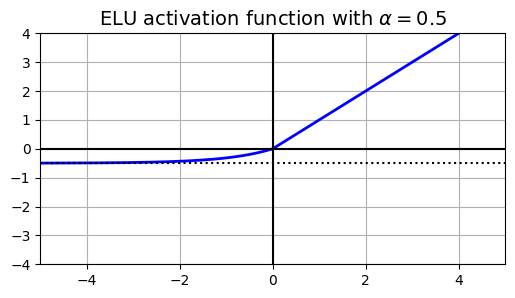

In [9]:
#plotting with alpha = 0.5
plt.figure(figsize=(6, 3))
plt.plot(z, elu(z, 0.5), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-0.5, -0.5], 'k:')
plt.plot([0, 0], [-4,4], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.title(r"ELU activation function with $\alpha=0.5$", fontsize=14)
plt.axis([-5, 5, -4, 4])

(-5.0, 5.0, -4.0, 4.0)

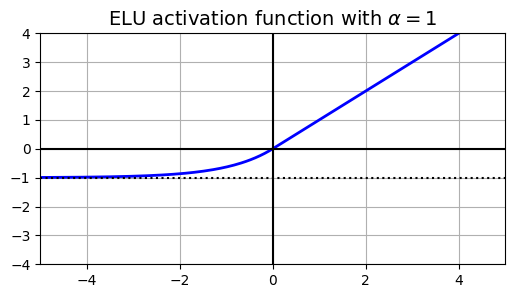

In [10]:
#plotting with alpha = 1
plt.figure(figsize=(6, 3))
plt.plot(z, elu(z, 1), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-4, 4], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.title(r"ELU activation function with $\alpha=1$", fontsize=14)
plt.axis([-5, 5, -4, 4])

differences btween ReLU and ELU:
* It takes on negative values for z < 0thus having aveage output close to 0. Thus helps reducing the vanishing gradients problem.
* $\alpha$ defines the value that ELU approaches when z<0 and is large 
* It has non zero gradient for z<0 thus helps reduce the dead nerons problem.
* If $\alpha$ = 1 the function is smooth everywhere which helps speed up the gradient descent as it does not bounce as much to the left and right of z=0.

6. Scaled ELU (SELU):

    * if all the layers use SELU then the network will self normalize. The output of each layer tend to preserve a mean of 0 and variance of 1 during training. Thus totally eliminating the vanishing/exploding gradient anomally.
    conditions for self-normalization are:

        * input features must be standardized 
        * every layer's weight must be initialized with LeCun normal initialization.\
            `kernel_initializer='lecun_normal'`
        * the network architechture must be sequential (like it should not be like wide and deep network)
        * This is effective for CNNs as well
    * By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:



<div style="font-family:C059">creating a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:</div>


In [11]:
np.random.seed(42)
tf.random.set_seed(42)

In [12]:
#building
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [13]:
# compiling
model.compile(loss="sparse_categorical_crossentropy",optimizer=keras.optimizers.SGD(learning_rate=1e-3),metrics=["accuracy"])

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full,y_train_full),(X_test,y_test) = fashion_mnist.load_data()
X_valid,X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0
X_test = X_test/255.0
y_valid,y_train = y_train_full[:5000], y_train_full[5000:]

now we scale the inputs to mean 0 and standard deviation 1

In [7]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [16]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 84s 38ms/step - loss: 1.1379 - accuracy: 0.5547 - val_loss: 0.9962 - val_accuracy: 0.6356
Epoch 2/5
1719/1719 [==============================] - 65s 38ms/step - loss: 0.7011 - accuracy: 0.7407 - val_loss: 0.6063 - val_accuracy: 0.7912
Epoch 3/5
1719/1719 [==============================] - 65s 38ms/step - loss: 0.5942 - accuracy: 0.7859 - val_loss: 0.5877 - val_accuracy: 0.7980
Epoch 4/5
1719/1719 [==============================] - 65s 38ms/step - loss: 0.5389 - accuracy: 0.8072 - val_loss: 0.5198 - val_accuracy: 0.8244
Epoch 5/5
1719/1719 [==============================] - 65s 38ms/step - loss: 0.5338 - accuracy: 0.8112 - val_loss: 0.6266 - val_accuracy: 0.7704


### <div style="font-family:fantasy;">Batch Normalization</div>
working:\
Adding an operation in the model just before or after activation function of each hidden layer. This operation simply zero centers and normalizes each input then scales ans shifts the result using two new paramter vectors per layer. One for scaling and other for shifting. The operation lets model learn the optimal scale and mean of each layer's input.If you add a BN layer as the very first layer of your neural network, you do not need to standardize your train‐
ing set (e.g., using a StandardScaler); the BN layer will do it for you (well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature).\
The algoritm estimates each input's mean and standard deviation. It does so by evaluating the mean and standard deviation of input over current mini batch.

Algorithm:
1. $\mathbf{\mu_B} = \frac{1}{m_B} \sum_{i=1}^{m_B}\mathbf{x}^{(i)}$
2. $\mathbf{\sigma_B}^2 = \frac{1}{m_B} \sum_{i=1}^{m_B}(\mathbf{x}^{(i)}-\mathbf{\mu_B})^2$
3. $\mathbf{\hat{x}^{(i)}} = \frac{\mathbf{x}^{(i)}-\mathbf{\mu_B}}{\mathbf{\sigma_B}^2 - \varepsilon}$
4. $\mathbf{z}^{(i)} = \gamma \otimes \mathbf{\hat{x}^{(i)}} + \mathbf{\beta}$

    * $\mathbf{\mu_B}: \text{mean of the mini batch}$
    * $\mathbf{\sigma_B}: \text{std. deviation of the mini batch}$
    * $m_B: \text{number of instances in the mini the mini batch}$
    * $\mathbf{\hat{x}^{(i)}}: \text{vector of zero centered normalized inputs for the i}^{th} \text{ instance}$
    * $\otimes: \text{element wise multiplication}$
    * $\varepsilon: \text{tiny number that helps avoiding division by zero}$
    * $\mathbf{z}^{(i)}: \text{output of the batch normalization operation. It is rescaled and shifted version of the inputs}$

advantages and limitations:\
So during training, BN standardizes its inputs, then rescales and offsets them. But is faces problems during the testing. we may need to make predictions for individual instances rather than for batches of instances: in this case, we
will  have  no  way  to  compute  each  input’s  mean  and  standard  deviation.  Moreover,
even if we do have a batch of instances, it may be too small, or the instances may not
be  independent  and  identically  distributed,  so  computing  statistics  over  the  batch
instances would be unreliable. One solution could be to wait until the end of training,
then  run  the  whole  training  set  through  the  neural  network  and  compute  the  mean
and standard deviation of each input of the BN layer. These “final” input means and
standard  deviations  could  then  be  used  instead  of  the  batch  input  means  and  stan‐
dard  deviations  when  making  predictions. Most  implementations  of  Batch
Normalization estimate these final statistics during training by using a moving aver‐
age of the layer’s input means and standard deviations.  μ  and  σ  are  estimated  during
training,  but  they  are  used  only  after  training  (to  replace  the  batch  input  means  and
standard deviations in Equation). Thus batch normalization helps us to use any activation function of our wish and any weight initializer as it normalizes the data by performing it in a totally separate layer the `BatchNormalization` layer in keras. BN acts like regularizer as well reducing the need of other regularization  techniques  (such  as  dropout).

though BN add complexity to the model thus NN makes slower predictions due to the extra computations required at each layer. Though it is often possible to fuse BN layer with the previous layer after training thus avoiding the runtime penalty. This is done by updating the previous layer’s weights and biases so that it directly produces  outputs  of  the  appropriate  scale  and offset. 

example:
if the previous layer computes $out = \mathbf{X}\mathbf{W}+\mathbf{b}$ then the BN layer will compute $out = \mathbf{\gamma}\otimes\frac{(\mathbf{X}\mathbf{W}+\mathbf{b}-\mathbf{\mu})}{\mathbf{\sigma}}+\mathbf{\beta}$\
Now, if we define $\mathbf{W'} = \mathbf{\gamma}\otimes\frac{\mathbf{W}}{\mathbf{\sigma}}$ and $\mathbf{b'} = \mathbf{\gamma}\otimes\frac{\mathbf{b}-\mathbf{\mu}}{\mathbf{\sigma}}+\mathbf{\beta}$,\
Now the equation becomes $out = \mathbf{X}\mathbf{W'}+\mathbf{b'}$. Or we replaced the previous layers weight and biases with updated weight and biases so that we can get rid of the BN layer.

##### <div style="font-family:fantasy;">Implementing Batch Normalization with keras</div>
Just  add  a  `BatchNormalization`  layer  before  or  after  each  hidden  layer’s activation  function,  and  optionally  add  a  BN  layer  as  well  as  the  first  layer  in  your
model.

In [17]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300,activation=keras.activations.elu,kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100,activation=keras.activations.elu,kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10,activation=keras.activations.softmax)
])


In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_105 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_106 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

Here the parameters $\mathbf{\mu}$ and $\mathbf{\sigma}$ are moving averages i.e. they are not affected by backpropagation so they are listed as non-trainale.

In [19]:
[(var.name,var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

Now it also creates two operations that will be called by the keras at each iteration during training.

In [20]:
model.layers[1].updates

C:\Users\ipsit\AppData\Local\Temp\ipykernel_6596\3873162892.py:1: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  model.layers[1].updates


[]

To add BN layer before the activation function we add the activation function as separate layers after the BN layer. Since batch normalization  layer includes one offset parameter per input, we can remove the bias term from the previous layer(by using `use_bias=False`)


In [21]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(10, activation="softmax")
])

<u>`momentum` hyperparameter</u>: this is used while updating the exponential moving averages; given a new value $\mathbf{v}$  (i.e.,  a  new  vector  of  input  means or  standard  deviations  computed  over  the  current  batch),  the  layer  updates  the  running average $\hat{\mathbf{v}}$ using the following equation:
$$
\hat{\mathbf{v}} \leftarrow \hat{\mathbf{v}} \times momentum + \mathbf{v} \times (1-momentum)
$$
A good momentum value is typically close to one.

<u>`axis` hyperparameter</u>: it determines which axis is to be normalized. By default it normalizes the last axis.\
ex:<div style="border:2px solid;width:50vw;border-radius:4px;"> When the input
    batch  is  2D  (i.e.,  the  batch  shape  is  [batch  size,  features]),  this  means  that  each  input
    feature  will  be  normalized  based  on  the  mean  and  standard  deviation  computed
    across  all  the  instances  in  the  batch.  For  example,  the  first  BN  layer  in  the  previous
    code  example  will  independently  normalize  (and  rescale  and  shift)  each  of  the  784
    input features. If we move the first BN layer before the Flatten layer, then the input
    batches will be 3D, with shape [batch size, height, width]; therefore, the BN layer will
    compute  28  means  and  28  standard  deviations  (1  per  column  of  pixels,  computed
    across  all  instances  in  the  batch  and  across  all  rows  in  the  column),  and  it  will  nor‐
    malize  all  pixels  in  a  given  column  using  the  same  mean  and  standard  deviation.
    There will also be just 28 scale parameters and 28 shift parameters. If instead you still
    want to treat each of the 784 pixels independently, then you should set axis=[1, 2]</div>

BN layer uses batch statistics during the training and final statistics after the training(i.e the final values of moving averages).
here's how the BN actually works 
```
class BatchNormalization(keras.layers.Layer):
    [...]
    def call(self,inputs,training=None):
        [...]
```
if we want to make a custom layer that must behave differently during the training and testing then we must add an extra layer in the `call()` namely `training`. Here it is set to `None` by default but during the training it is set to `1`.

<div style="font-family:Ani;font-size:22px">by using a novel fixed-update (fixup) weight initialization technique, the
authors  managed  to  train  a  very  deep  neural  network  (10,000  layers!)  without  BN, achieving state-of-the-art performance on complex image classification tasks</div>

### <div style="font-family:fantasy;">Gradient Clipping</div>
* used especially in RNN as using batch normalization is difficult there. 
* works of the principle of clipping the gradient to a fixed value when it increases a particular threshold. 
* use to aleviate exploding gradients problem.
```
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="mse",optimizer=optimizer)
```
This clips all the values of the gradient vector between -1 and 1. This means that all the partial derivatives of the loss wrt all the trainable parameter will be shifted between -1 and 1. because of this the direction of the gradinet vector gets altered. To resolve this we clip the gradients by norm. This is done by using `clipnorm` instead of `clipvalue`. For  example,  if  you  set  clipnorm=1.0,  then  the  vector  [0.9,  100.0]
will be clipped to [0.00899964, 0.9999595], preserving its orientation but almost eliminating the first component. Though we can use both and check which works best for our dataset.

# <div style="font-family:fantasy;">Reusing Pretrained Layers</div>
we can user the lower layers of a pretrained model that is trained to do a similar task as we are trying to do. This techinque is called *transfer learning*. It will not only speed up the training but also require less training data.

<img src="https://dsm04pap003files.storage.live.com/y4mSq9V0M8LeQHcqA637PQYbjNQ8SfFBEtStzQU1AzTPU9TyQWTavcAwtaecsUHVIt2V6mpm8xA33Z_yygsruHUVvqNTGFESu-1jH-JrO-2Dls_0bVp_BY7KrujtYYVwOnzOyFQ2nhbgh77Wnf3zfv2Dxz6pHGaT6OORZBVSSChJxp4S5Ixu2b5Ep7Z4gWRmJ-y?width=544&height=375&cropmode=none" width="544" height="375" />

the upper hidden layers of the original model are less likely to be as useful as the lower layer, since high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. But the output layer needs to be different (obviously!!!).

Now to find the number of layers to use, 
1. we freeze all the resued layers at first(i.e. making their weights non-trainable or unaffected by the gradient descent). Then we train the model and note the performance.
2. we unfreeze one or two of the top hidden layers to let the backpropgation tweak them and note if the performance improves(it is better to reduce the learning rate after unfreezing as this will avoid wrecking their fine-tuned weights.){more the training data more layers we can unfreeze}.

If you still cannot get good performance, and you have little training data, try drop‐
ping  the  top  hidden  layer(s)  and  freezing  all  the  remaining  hidden  layers  again.  You
can  iterate  until  you  find  the  right  number  of  layers  to  reuse.  If  you  have  plenty  of
training data, you may try replacing the top hidden layers instead of dropping them,
and even adding more hidden layers.


### <div style="font-family:fantasy;">Transfer learning with keras</div>
we here use fashion mnist dataset and divide it into two datasets one without the images of sandals and shirt and other small datasetn with only 200 images of sandals or shirt. we here are intended to build a binary classifier with shirt as positive class and sandals as negative class.
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image)

In [6]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: if it is a shirt then set 1 (positive class)
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [23]:
tf.random.set_seed(42)
np.random.seed(42)

In [24]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28],name="inp_layer"))
i=1
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu",name=f"hidden_{i}"))
    i+=1
model_A.add(keras.layers.Dense(8, activation="softmax",name="out_layer"))

In [25]:
model_A.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp_layer (Flatten)         (None, 784)               0         
                                                                 
 hidden_1 (Dense)            (None, 300)               235500    
                                                                 
 hidden_2 (Dense)            (None, 100)               30100     
                                                                 
 hidden_3 (Dense)            (None, 50)                5050      
                                                                 
 hidden_4 (Dense)            (None, 50)                2550      
                                                                 
 hidden_5 (Dense)            (None, 50)                2550      
                                                                 
 out_layer (Dense)           (None, 8)                

In [26]:
model_A.compile(loss="sparse_categorical_crossentropy",optimizer=keras.optimizers.SGD(learning_rate=1e-3),metrics=["accuracy"])

In [27]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 19s 13ms/step - loss: 0.6228 - accuracy: 0.7961 - val_loss: 0.4023 - val_accuracy: 0.8662
Epoch 2/20
1375/1375 [==============================] - 12s 9ms/step - loss: 0.3631 - accuracy: 0.8764 - val_loss: 0.3322 - val_accuracy: 0.8842
Epoch 3/20
1375/1375 [==============================] - 12s 9ms/step - loss: 0.3188 - accuracy: 0.8893 - val_loss: 0.3018 - val_accuracy: 0.8999
Epoch 4/20
1375/1375 [==============================] - 12s 9ms/step - loss: 0.2979 - accuracy: 0.8973 - val_loss: 0.2883 - val_accuracy: 0.9016
Epoch 5/20
1375/1375 [==============================] - 10s 7ms/step - loss: 0.2838 - accuracy: 0.9021 - val_loss: 0.2760 - val_accuracy: 0.9068
Epoch 6/20
1375/1375 [==============================] - 10s 7ms/step - loss: 0.2740 - accuracy: 0.9057 - val_loss: 0.2709 - val_accuracy: 0.9063
Epoch 7/20
1375/1375 [==============================] - 13s 9ms/step - loss: 0.2655 - accuracy: 0.9096 - val_loss: 0.2670 - val_a

In [28]:
model_A.save("./models/model_A_MNIST.h5")

In [29]:
model_A = keras.models.load_model("./models/model_A_MNIST.h5")

In [30]:
model_A.summary()#type:ignore

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp_layer (Flatten)         (None, 784)               0         
                                                                 
 hidden_1 (Dense)            (None, 300)               235500    
                                                                 
 hidden_2 (Dense)            (None, 100)               30100     
                                                                 
 hidden_3 (Dense)            (None, 50)                5050      
                                                                 
 hidden_4 (Dense)            (None, 50)                2550      
                                                                 
 hidden_5 (Dense)            (None, 50)                2550      
                                                                 
 out_layer (Dense)           (None, 8)                

In [31]:
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])#type:ignore
model_B_on_A.add(keras.layers.Dense(1,activation=keras.activations.sigmoid))


Now the problem is training `model_B_on_A` will affect `model_A` as `model_A`'s layers are being directly used by `model_B_on_A`. Thus to avoid this we clone `model_A`. But even then the weights will not be cloned thus we need to clone the weights separately.

In [32]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())#type:ignore

Now during training `model_B_on_A` since the output layer is randomly added, it will make large errors atleast during first few epochs. So there will be large error gradients that may wreck the reused weights. To avoid this one approach is to freeze the reused layers during the first few epochs giving the new layer some time to learn reasonable weights.

In [33]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable=False


In [34]:
#now we compile the model
model_B_on_A.compile(loss='binary_crossentropy',optimizer='sgd',metrics=["accuracy"])

In [35]:
history = model_B_on_A.fit(X_train_B,y_train_B,epochs=4,validation_data=(X_valid_B,y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 68ms/step - loss: 0.4077 - accuracy: 0.7700 - val_loss: 0.3174 - val_accuracy: 0.8641
Epoch 2/4
7/7 [==============================] - 0s 33ms/step - loss: 0.2783 - accuracy: 0.8900 - val_loss: 0.2384 - val_accuracy: 0.9229
Epoch 3/4
7/7 [==============================] - 0s 32ms/step - loss: 0.2105 - accuracy: 0.9250 - val_loss: 0.1944 - val_accuracy: 0.9493
Epoch 4/4
7/7 [==============================] - 0s 34ms/step - loss: 0.1715 - accuracy: 0.9550 - val_loss: 0.1644 - val_accuracy: 0.9615


Now we unfreeze the reused layers and use recompile the `model_B_on_A` and then fit the data. Also we should lower the learning rate which is by default `1e-2`

In [36]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable=True
optimizer = keras.optimizers.SGD(learning_rate=1e-4)
model_B_on_A.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])


In [37]:
history = model_B_on_A.fit(X_train_B,y_train_B,epochs=16,validation_data=(X_valid_B,y_valid_B))

Epoch 1/16
7/7 [==============================] - 2s 90ms/step - loss: 0.1517 - accuracy: 0.9700 - val_loss: 0.1618 - val_accuracy: 0.9635
Epoch 2/16
7/7 [==============================] - 0s 40ms/step - loss: 0.1490 - accuracy: 0.9700 - val_loss: 0.1595 - val_accuracy: 0.9645
Epoch 3/16
7/7 [==============================] - 0s 43ms/step - loss: 0.1464 - accuracy: 0.9700 - val_loss: 0.1572 - val_accuracy: 0.9645
Epoch 4/16
7/7 [==============================] - 0s 34ms/step - loss: 0.1439 - accuracy: 0.9700 - val_loss: 0.1550 - val_accuracy: 0.9665
Epoch 5/16
7/7 [==============================] - 0s 47ms/step - loss: 0.1414 - accuracy: 0.9700 - val_loss: 0.1530 - val_accuracy: 0.9665
Epoch 6/16
7/7 [==============================] - 0s 39ms/step - loss: 0.1392 - accuracy: 0.9700 - val_loss: 0.1511 - val_accuracy: 0.9675
Epoch 7/16
7/7 [==============================] - 0s 30ms/step - loss: 0.1371 - accuracy: 0.9700 - val_loss: 0.1492 - val_accuracy: 0.9675
Epoch 8/16
7/7 [===========

In [38]:
model_B_on_A.evaluate(X_test_B,y_test_B)

63/63 [==============================] - 0s 5ms/step - loss: 0.1333 - accuracy: 0.9780


[0.13329514861106873, 0.9779999852180481]

But actually this is just framed if we change the random seed by a little bit then the improvements may vanish. Lesson: You should be always suspicious about perfection because nothing is perfect it might be a pretending model in that particular data. This is called "torturing till confession".

It  turns  out  that  transfer  learning  does  not  work  very  well  with
small  dense  networks,  presumably  because  small  networks  learn  few  patterns,  and
dense  networks  learn  very  specific  patterns,  which  are  unlikely  to  be  useful  in  other
tasks.  Transfer  learning  works  best  with  deep  convolutional  neural  networks,  which
tend  to  learn  feature  detectors  that  are  much  more  general  (especially  in  the  lower
layers).

### <div style="font-family:fantasy;">Unsupervised Pretraining</div>
If we have lots of unlabelled training data but very few labelled data and we cannot find a similar model trained on that then *unsupervised pretrained* can help.

we can gather plenty of unlabelled data and train as unsupervised model on it such as autoencoders or generative adversarial network. Then we can use the lower layers of autoencoder or GAN discriminator, add the output layer for our task on the top and fine tune the final network using supervised learning(i.e with some labelled training examples).

In earlier days people used to train the deep learning models using a technique called *greedy layer-wise pretraining*. Here they would first train an unsupervised model with a single layer, typically an Restricted Boltzmann Machine(RBM), then would freeze that layer and add another one on top of it, then train the model again (effectively just training the new layer), then freeze this new layer and another on top of it train the model again and so on. Now a days these models are being trained in one shot using autoencoders and GAN descriminators rather than RBMs.

<img src="https://dsm04pap003files.storage.live.com/y4mwB6oc5ckhN7BmpMSpT9noPoRuIE3CDbhKApugtC5w-2ByKyHW7i1u0IZYBVBKZcyHTA0lJHx3SuTtJ08whirId8sN1S6gy8OoexQsnc3ZiGgvmxypVdN552MnlhwTeVEdwgn781Y7H4tawqJsTNm_M2wBFjBe3kclK148-NLROpq-ncfIcFoM1W16y4ft5lf?width=710&height=473&cropmode=none" width="510" height="273" />

### <div style="font-family:fantasy;">Pretraining on an Auxiliary Task</div>
If you do not have much labeled training data, one last option is to train a first neural
network  on  an  auxiliary  task  for  which  you  can  easily  obtain  or  generate  labeled
training  data,  then  reuse  the  lower  layers  of  that  network  for  your  actual  task.  The
first neural network’s lower layers will learn feature detectors that will likely be reusa‐
ble by the second neural network.

For  example,  if  you  want  to  build  a  system  to  recognize  faces,  you  may  only  have  a
few pictures of each individual—clearly not enough to train a good classifier. Gather‐
ing hundreds of pictures of each person would not be practical. You could, however,
gather a lot of pictures of random people on the web and train a first neural network
to  detect  whether  or  not  two  different  pictures  feature  the  same  person. Such a network  would  learn  good  feature  detectors  for  faces,  so  reusing  its  lower  layers
would allow you to train a good face classifier that uses little training data. 

For  natural  language  processing  (NLP)  applications,  you  can  download  a  corpus  of
millions of text documents and automatically generate labeled data from it. For exam‐
ple, you could randomly mask out some words and train a model to predict what the
missing words are (e.g., it should predict that the missing word in the sentence “What
___ you saying?” is probably “are” or “were”). If you can train a model to reach good
performance  on  this  task,  then  it  will  already  know  quite  a  lot  about  language,  and
you  can  certainly  reuse  it  for  your  actual  task  and  fine-tune  it  on  your  labeled  data.


# <div style="font-family:fantasy;">Fast Optimizers</div>
Another huge speed boost in training of DNN come from using faster optimizers rather than Gradient Descent optimizer.

### <div style="font-family:fantasy;">Momentum optimiation</div>
Imagine  a  bowling  ball  rolling  down  a  gentle  slope  on  a  smooth  surface:  it  will  start
out slowly, but it will quickly pick up momentum until it eventually reaches terminal
velocity (if there is some friction or air resistance). This is the very simple idea behind
*momentum  optimization*. while gradient descent will take small regular steps down the slope, so the algorithm will take muvh more time to reach the bottom.\
In gradient Descent the weights are updated by directly subtracting the gradient of the cost function $J(\mathbf{\theta})$ with regrards to the weights $\mathbf{\theta}$ i.e. ($\nabla_{\theta}J({\mathbf{\theta}})$). Or by equation,
>$$\mathbf{\theta}\leftarrow\mathbf{\theta}-\eta\nabla_{\theta}J({\mathbf{\theta}})$$
It does not care about the earlier gradients.

Momentum  optimization  cares  a  great  deal  about  what  previous  gradients  were:  at
each  iteration,  it  subtracts  the  local  gradient  from  the  _momentum_  vector  **m**  (multiplied  by  the  learning  rate  η),  and  it  updates  the  weights  by  adding  this  momentum
vector . In other words, the gradient is used for acceleration, not
for speed. To simulate some sort of friction mechanism and prevent the momentum
from growing too large, the algorithm introduces a new hyperparameter β, called the
momentum, which must be set between 0 (high friction) and 1 (no friction). A typical
momentum value is 0.9.

*momentum algorithm*

>$\mathbf{m}\leftarrow\beta\mathbf{m}-\eta\nabla_{\theta}J({\mathbf{\theta}})$

>$\mathbf{\theta}\leftarrow\mathbf{\theta}+\mathbf{m}$

Now the speed increases to a certain value and stops increasing. OR, we can say that the rate of change of momentum is constant and the terminal velocity(i.e. the maximum size of weight updates) is equal to $gradient\text{(the acceletation or rate of change of momentum)}\times\frac{1}{1-\beta}$.\
Thus, similar to general physics considering $\beta$ as coefficient of friction. The terminal velocity will be inversely proportional to $\beta$. Thus for a $\beta$ this algorithm goes $\frac{1}{1-\beta}$ tmes faster than gradient descent. This will go down the valley faster and faster until it reaches the minimum. In DNN without batch normalization upper layers will often end up having inputs with very different scales so using momentum optimization helps.

    optimizer = keras.optimizers.SGD(lr=0.001,momentum=0.9)

where $\beta$ is defined by the `momentum` hyperparameter.
Only one drawback is it adds another hyperparameter to tune. Though 0.9 momentum value works well.

### <div style="font-family:fantasy;">Nesterov Accelerated Gradient</div>
It measures the gradient of the cost function not at the local position function not at the local position but slightly ahead in the direction of momentum at $\boldsymbol{\theta}+\beta \mathbf{m}$.
>$\boldsymbol{m}\leftarrow\beta\boldsymbol{m}-\eta\nabla_{\boldsymbol{\theta}}(\boldsymbol{\theta}+\beta\boldsymbol{m})$

>$\boldsymbol{\theta}\leftarrow\boldsymbol{\theta}+\boldsymbol{m}$

Momentum points towards the optimum. So it will be slightly more accurate to use gradient measured a bit farther in that direction rather than the gradient at the same position. Also this ends slightly closer to the optimum. Now finally these small improvements add up and NAG ends up being significantly faster than the regular momentum optimization. Also, it is always a bit closer to the optimum. Thus pushing more towards the valley. This helps it to converge faster.

    optimizer = keras.optimizers.SGD(lr=0.001,momentum=0.9,nesterov=True)

### <div style="font-family:fantasy;">Ada Grad</div>
This algortihm corrects the direction of progress to point more where the gradient is more inclined towards the goal at an earlier phase. Quite like the nesterov's accelerated gradient.

*AdaGrad algorithm*
>$\mathbf{s}\leftarrow\mathbf{s}+\nabla_{\mathbf{\theta}}J(\mathbf{\theta})\otimes\nabla_{\mathbf{\theta}}J(\mathbf{\theta})$

>$\mathbf{\theta}\leftarrow\mathbf{\theta}-\eta\nabla_{\mathbf{\theta}}J(\mathbf{\theta})\oslash\sqrt{\mathbf{s}+\varepsilon}$

Now the first equation accumulates the sqare of the gradients to the vector $\mathbf{s}$. $\nabla_{\mathbf{\theta}}J(\mathbf{\theta})\otimes\nabla_{\mathbf{\theta}}J(\mathbf{\theta})$ can also be written as $(\frac{\partial{J(\boldsymbol{\theta})}}{\partial\theta_i})^2 \forall i=0\rightarrow n$.\
Thus equation $s_i\leftarrow s_i+(\frac{\partial{J(\boldsymbol{\theta})}}{\partial\theta_i})^2$ for each element $s_i$ of vector $\vec{s}$. OR, each $s_i$ accumulates the square of partial derivatives of cost function with regards to $\theta_i$ if cost function is steeper along $\theta_i$ then $s_i$ will get larger and larger over each iteration.\
In the second equation gradient is scaled down by a factor $\sqrt{\mathbf{s}+\varepsilon}$, so as to reach to a point of steeper gradient but at an early stage.\
Thus, it decays the learning rate by a factor $\sqrt{\mathbf{s}+\varepsilon}$ but does it faster for the steep dimension rather than gentler sloped dimensions. This is called adaptive learning rate.

<img src="https://dsm04pap003files.storage.live.com/y4mszbW29OdilLYFz5UCsnUzMUposUnLP3DJ5fXjVdrSuFg9pyaqP-wcYi65O7FJdUoKvQvS_2PDdNQyijDtimvJJmrIgE5SHVwWN0y2pYhSs6yL0oGu1oYAgkcDwex8RQZhAjzHVQ7_8CCH2RuEeIpy221YRtQaO1HmJ0AX-3wIrdJ1PhFTM9qf_3sARU5A3yy?width=2659&height=2034&cropmode=none" width="459" height="334" />

### <div style="font-family:fantasy;">RMS Prop</div>
Ada grad risks slowing down to fast and never converging to global optimum.

RMS prop fixes this by accumulating onlygradients from most recent iterations(as opposed to all the gradients in the gradients). It does so by using exponential decays in the first step.

>$\mathbf{s}\leftarrow\beta\mathbf{s}+(1-\beta)\nabla_{\boldsymbol{\theta}}J({\boldsymbol{\theta}})\otimes\nabla_{\boldsymbol{\theta}}J({\boldsymbol{\theta}})$

>$\boldsymbol{\theta}\leftarrow\boldsymbol{\theta}-\eta\nabla_{\boldsymbol{\theta}}J({\boldsymbol{\theta}})\oslash\sqrt{\mathbf{s}+\varepsilon}$

The decay rate $\beta=0.9$ generally works.

    optimizer = keras.optimizers.RMSprop(lr=0.001,rho=0.9)

`rho` defines $\beta$

### <div style="font-family:fantasy;">Adam and Nadam Optimizaation</div>
$Adaptive \ momentum \ estimation = momentum \ optimization + RMSprop$

Like momentum optimization it keeps track of an exponentially decaying average of past gradients.

Like RMSprop it keeps tracks of an exponentially decaying average of past squared gradients.

1. $\mathbf{m}\leftarrow\beta_1\mathbf{m} - (1-\beta_1)\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$
2. $\mathbf{s}\leftarrow\beta_2\mathbf{s} - (1-\beta_2)\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})\otimes\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$
3. $\widehat{\mathbf{m}}\leftarrow\frac{\mathbf{m}}{1-\beta_1^t}$
4. $\widehat{\mathbf{s}}\leftarrow\frac{\mathbf{s}}{1-\beta_2^t}$
5. $\boldsymbol{\theta}\leftarrow\boldsymbol{\theta}+\eta\widehat{\boldsymbol{m}}\oslash\sqrt{\widehat{\mathbf{s}}+\varepsilon}$

Here $t$ represents the iteration count. The difference between RMSprop and momentum optimization is in step 1 it computes the exponentially decaying average, rather that just the sum. Though these are equivalent they differ only by a constant factor: decaying average is $(1-\beta_1)$ times the decaying sum. In step 2 and 4 **m** and **s** are initialized at 0, they will be biased toward 0 at the beginning of training,so these two steps will help boost **m** and **s** at the beginning of training. The momentum decay hyperparameter $β_1$ is typically initialized to 0.9, while the scaling  decay  hyperparameter  $β_2$  is  often  initialized  to  0.999.  As  earlier,  the  smoothing term $ε$ is usually initialized to a tiny number such as 10–7.

    optimizer = keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

as it is an adaptive algorithm it requires less tuning of learning rate $\eta$

variants of adam's optimization:

*AdaMax*\
In step 5 Adam scales down the parameter updates by $\ell_2$ norm of the time-decayed gradients. Adamax does the same thing but by using $\ell_\infty$, which is practically finding the maximum of the cumulation vector $\mathbf{s}$ . OR, specifically it replaces step 2 with $\mathbf{s}\leftarrow max(\beta_2\mathbf{s},\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta}))$ and drops down step 4 and in 5 it scales down the gradients by a factor $\mathbf{s}$ which is just the max of the time decayed gradients.
In step 5 Adam scales down the parameter updates by $\ell_2$ norm of the time-decayed gradients. Adamax does the same thing but by using $\ell_\infty$, which is practically finding the maximum of the cumulation vector $\mathbf{s}$ . OR, specifically it replaces step 2 with $\mathbf{s}\leftarrow max(\beta_2\mathbf{s},\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta}))$ and drops down step 4 and in 5 it scales down the gradients by a factor $\mathbf{s}$ which is just the max of the time decayed gradients.\
Thus, algortihm is:

1. $\mathbf{m}\leftarrow\beta_1\mathbf{m} - (1-\beta_1)\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$
2. $\mathbf{s}\leftarrow max(\beta_2\mathbf{s},\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta}))$
3. $\widehat{\mathbf{m}}\leftarrow\frac{\mathbf{m}}{1-\beta_1^t}$
4. $\widehat{\mathbf{s}}\leftarrow\frac{\mathbf{s}}{1-\beta_2^t}$
5. $\boldsymbol{\theta}\leftarrow\boldsymbol{\theta}+\eta\widehat{\boldsymbol{m}}\oslash(\widehat{\mathbf{s}}+\varepsilon)$

*Nadam*\
$Nadam = Adam+Nesterov$\
Thus is converges slightly faster than adam. It is sometimes outperformed by RMSprop.

<div style="padding: 5px;border: 2px solid;border-radius: 4px;justify-content: center;align-items:center;width:50vw">
    All  the  optimization  techniques  discussed  so  far  only  rely  on  the  first-order  partial
    derivatives  (Jacobians).  The  optimization  literature  also  contains  amazing  algorithms
    based  on  the  second-order  partial  derivatives  (the  Hessians,  which  are  the  partial
    derivatives  of  the  Jacobians).  Unfortunately,  these  algorithms  are  very  hard  to  apply
    to  deep  neural  networks  because  there  are  n2  Hessians  per  output  (where  n  is  the
    number of parameters), as opposed to just n Jacobians per output. Since DNNs typically have tens of thousands of parameters, the second-order optimization algorithms often  don’t  even  fit  in  memory,  and  even  when  they  do,  computing  the  Hessians  is
    just too slow.
</div>

### <div style="font-family:fantasy;">Learning Rate Scheduling</div>
If  you  set  it  much  too  high,  training
may  diverge  If  you  set  it  too
low,  training  will  eventually  converge  to  the  optimum,  but  it  will  take  a  very  long
time.  If  you  set  it  slightly  too  high,  it  will  make  progress  very  quickly  at  first,  but  it
will  end  up  dancing  around  the  optimum,  never  really  settling  down. If  you  have  a
limited computing budget, you may have to interrupt training before it has converged
properly, yielding a suboptimal solution.  you  can  find  a  good  learning  rate  by  training  the
model for a few hundred iterations, exponentially increasing the learning rate from a
very  small  value  to  a  very  large  value,  and  then  looking  at  the  learning  curve  and
picking  a  learning  rate  slightly  lower  than  the  one  at  which  the  learning  curve  starts
shooting back up. You can then reinitialize your model and train it with that learning
rate.

We can do better with non-constant learning rate. That is we start with a very high leanring rate and lower it once the algorithm stops making fast rogress, in this way we can make fast progress to reach a good solution faster than with constant learning rate.

*Power Scheduling*\
Here we set the learning rate as a function of the iteration count $t$,
$$\eta(t) = \frac{\eta_0}{(1+\frac{t}{s})^c}$$
The lr drops to half after $s$ steps then to one-third after another $s$ steps or net $2s$ steps and so on(if the power $c$ is set to 1, which is the general case). Thus the learning rate reduced at a faster rate initially and then the pace reduces. $\eta_0$ is the initial learning rate.

*exponential scheduling*\
Here the learning rate reduces by a factor of 10 after every *s* steps. Here the count does not fix to sequence of 1 but a power of 10 after every *s* steps.
$$\eta(t) = \frac{\eta_0}{10^{\frac{t}{s}}}$$

*piecewise constant scheduling*\
Use a constant learning rate for a number of epochs (e.g., $η_0$ = 0.1 for 5 epochs),
then a smaller learning rate for another number of epochs (e.g., $η_1$ = 0.001 for 50
epochs),  and  so  on.  Although  this  solution  can  work  very  well,  it  requires  fid‐
dling  around  to  figure  out  the  right  sequence  of  learning  rates  and  how  long  to
use each of them.

*performance scheduling*\
Measure  the  validation  error  every  N  steps  (just  like  for  early  stopping),  and
reduce the learning rate by a factor of λ when the error stops dropping.

*1cycle scheduling*\
starts  by  increasing  the  initial  learning  rate  η0,  growing  linearly  up  to  η1
halfway through training. Then it decreases the learning rate linearly down to η0
again  during  the  second  half  of  training,  finishing  the  last  few  epochs  by  drop‐
ping the rate down by several orders of magnitude (still linearly). The maximum
learning  rate  η1  is  chosen  using  the  same  approach  we  used  to  find  the  optimal
learning  rate,  and  the  initial  learning  rate  η0  is  chosen  to  be  roughly  10  times
lower.  When  using  a  momentum,  we  start  with  a  high  momentum  first  (e.g.,
0.95),  then  drop  it  down  to  a  lower  momentum  during  the  first  half  of  training
(e.g.,  down  to  0.85,  linearly),  and  then  bring  it  back  up  to  the  maximum  value
(e.g.,  0.95)  during  the  second  half  of  training,  finishing  the  last  few  epochs  with
that  maximum  value. 

In [ ]:
#implementing power scheduling
optimizer_2 = keras.optimizers.SGD(learning_rate=0.01,decay=1e-4)

`decay` is $\frac{1}{s}$ and $c$ is assumed to be 1 in keras.

In [1]:
#implementing exponential scheduling 
def exponential_decay(eta0,s):
    return lambda epoch:eta0//(10**(epoch/s))

In [4]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay(eta0=0.01,s=20))

Now we can use this as a callback argument
```python
history = model.fit(X_train_scaled, y_train, [...], callbacks=[lr_scheduler])
```

Updating  the  learning  rate  once  per  epoch  is  usually
enough,  but  if  you  want  it  to  be  updated  more  often,  for  example  at  every  step,  you
can always write your own callback

```python
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        K.set_value(self.model.optimizer.learning_rate, lr * 0.1**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
```

Updating  the  learning  rate  at  every  step  makes  sense  if
there  are  many  steps  per  epoch

else we can also use:
```python
keras.optimizers.schedules
```

The schedule function can optionally take the current learning rate as a second argu‐
ment.  For  example,  the  following  schedule  function  multiplies  the  previous  learning
rate  by  0.1<sup>1/20</sup>,  which  results  in  the  same  exponential  decay  (except  the  decay  now
starts at the beginning of epoch 0 instead of 1):

```python
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)
```

When  you  save  a  model,  the  optimizer  and  its  learning  rate  get  saved  along  with  it.
This means that with this new schedule function, you could just load a trained model
and continue training where it left off, no problem. Things are not so simple if your
schedule  function  uses  the  epoch  argument,  however:  the  epoch  does  not  get  saved,
and  it  gets  reset  to  0  every  time  you  call  the  `fit()`  method.  If  you  were  to  continue
training a model where it left off, this could lead to a very large learning rate, which
would likely damage your model’s weights. One solution is to manually set the `fit()`
method’s `initial_epoch` argument so the epoch starts at the right value

In [5]:
#implementing piecewise constant scheduling
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [6]:
# implementing performance scheduling
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=5)

 if
you pass the following callback to the `fit()` method, it will multiply the learning rate
by 0.5 whenever the best validation loss does not improve for five consecutive epochs

we can implement the same exponential scheduling using ```keras.optimizers.schedules```

In [9]:
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)


In [11]:
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)#type:ignore

In [12]:
#implementing 1cycle scheduling
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))#type:ignore
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)#type:ignore

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs#type:ignore
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

# <div style="font-family:fantasy;">Avoiding Overfitting Through Regularization</div>
### <div style="font-family:fantasy;">ℓ<sub>1</sub> and ℓ<sub>2</sub> Normalization</div>
here is how we can use $\ell_2$ optimization with keras,
```python
layer = keras.layers.Dense(100,activation='elu',kernel_initializer = 'he_normal',kernel_regularizer=keras.regularizers.l2(0.01))
```
The `l2()` function returns a regularizer that will be called at each step during training
to compute the regularization loss. This is then added to the final loss. As you might
expect,  you  can  just  use  keras.regularizers.`l1() ` if  you  want  ℓ$_1$  regularization;  if
you want both ℓ$_1$ and ℓ$_2$ regularization, use keras.regularizers.`l1_l2()` (specifying
both regularization factors)

To make the code a bit organized we can use the following,


```python
from functools import partial
RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax",
                     kernel_initializer="glorot_uniform")
])
```


### <div style="font-family:fantasy;">Dropout</div>
 at  every  training  step,  every  neuron  (including  the
input neurons, but always excluding the output neurons) has a probability *p* of being
temporarily  “dropped  out,”  meaning  it  will  be  entirely  ignored  during  this  training
step, but it may be active during the next step. The hyperparameter
*p* is called the dropout rate, and it is typically set between 10% and 50%: closer to 20–
30% in recurrent neural nets, and closer to 40–50% in convolutional
neural  networks.  After  training,  neurons  don’t  get  dropped  anymore. 

<img src="https://dsm04pap003files.storage.live.com/y4mHYO9cV2PJOvljKMY-mrhrNLd0Ilvh9OobL_-zfDzCngJT3DLIDyecNws2QFepkbqoD1RDypqQPZYxPOpHWUgkjFcr6iET-Io_R6jLmpvq3EljcYHfDgxWvo-qaKpZGHiQWi0-3j7J0UQdpS9yYbHC0NRrkXjEudYs88weEgDikQA3lpbRWUrF6xH8lxvc4MO?width=750&height=313&cropmode=none" width="750" height="313" />

Neurons  trained  with  dropout  cannot  co-adapt  with  their
neighboring  neurons;  they  have  to  be  as  useful  as  possible  on  their  own.  They  also
cannot rely excessively on just a few input neurons; they must pay attention to each of
their input neurons. They end up being less sensitive to slight changes in the inputs.
In the end, you get a more robust network that generalizes better.

There  is  one  small  but  important  technical  detail.  Suppose  *p*  =  50%,  in  which  case
during  testing  a  neuron  would  be  connected  to  twice  as  many  input  neurons  as  it
would be (on average) during training. To compensate for this fact, we need to multi‐
ply  each  neuron’s  input  connection  weights  by  0.5  after  training.  If  we  don’t,  each
neuron  will  get  a  total  input  signal  roughly  twice  as  large  as  what  the  network  was
trained on and will be unlikely to perform well. More generally, we need to multiply
each  input  connection  weight  by  the  *keep  probability*  (1  –  *p*)  after  training.  Alterna‐
tively,  we  can  divide  each  neuron’s  output  by  the  keep  probability  during  training
(these alternatives are not perfectly equivalent, but they work equally well).

`keras` does this division by default and we don't need to do it while using keras API.

In [11]:
#building
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])


In [12]:
#compile
optimizer = keras.optimizers.SGD(learning_rate=0.01,nesterov=True,momentum=0.9)
model.compile(loss=keras.losses.sparse_categorical_crossentropy,optimizer=optimizer,metrics=['accuracy'])

In [13]:
#fit 
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 26s 13ms/step - loss: 0.5605 - accuracy: 0.8009 - val_loss: 0.4137 - val_accuracy: 0.8524
Epoch 2/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.4535 - accuracy: 0.8350 - val_loss: 0.3747 - val_accuracy: 0.8696
Epoch 3/20
1719/1719 [==============================] - 20s 11ms/step - loss: 0.4194 - accuracy: 0.8474 - val_loss: 0.3490 - val_accuracy: 0.8726
Epoch 4/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3988 - accuracy: 0.8544 - val_loss: 0.3361 - val_accuracy: 0.8754
Epoch 5/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3938 - accuracy: 0.8554 - val_loss: 0.3263 - val_accuracy: 0.8768
Epoch 6/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3814 - accuracy: 0.8601 - val_loss: 0.3129 - val_accuracy: 0.8896
Epoch 7/20
1719/1719 [==============================] - 20s 11ms/step - loss: 0.3689 - accuracy: 0.8652 - val_loss: 0.3337 -

In [14]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 21s 12ms/step - loss: 0.3149 - accuracy: 0.8845


Since  dropout  is  only  active  during  training,  comparing  the  train‐
ing  loss  and  the  validation  loss  can  be  misleading.  In  particular,  a
model  may  be  overfitting  the  training  set  and  yet  have  similar
training and validation losses. So make sure to evaluate the training
loss without dropout (e.g., after training).

we should increase the rate if the model is overfitting and reduce it if it is underfitting. It  can  also  help  to  increase  the  dropout  rate  for  large  layers,  and  reduce  it  for small  ones.

Dropout does tend to significantly slow down convergence, but it usually results in a
much better model when tuned properly.

<div style="border:2px solid;border-radius:4px;width:50vw;">
If  you  want  to  regularize  a  self-normalizing  network  based  on  the
SELU  activation  function  (as  discussed  earlier),  you  should  use
alpha dropout: this is a variant of dropout that preserves the mean
and standard deviation of its inputs</div>

### <div style="font-family:fantasy;">Monte Carlo (MC) Dropout</div>
This can  boost  the  performance  of  any  trained  dropout  model  without  having  to
retrain it or even modify it at all, provides a much better measure of the model’s
uncertainty.

 full  implementation  of  MC  Dropout,  boosting  the  dropout  model
we trained earlier without retraining it

In [15]:
y_probas=np.stack([model(X_test_scaled,training=True) for sample in range(100)]) # type: ignore

In [17]:
y_probas.shape

(100, 10000, 10)

We just make 100 predictions over the test set, setting training=True to ensure that
the  Dropout  layer  is  active,  and  stack  the  predictions.  Since  dropout  is  active,  all  the
predictions will be different. Recall that `predict()` returns a matrix with one row per
instance and one column per class. Because there are 10,000 instances in the test set
and  10  classes,  this  is  a  matrix  of  shape  [10000,10].  We  stack  100  such  matrices,  so
`y_probas`  is  an  array  of  shape  [100,10000,10]

In [18]:
y_proba = y_probas.mean(axis=0)

In [19]:
y_proba.shape

(10000, 10)

Once we average over the first dimension we get `y_proba` an array of shape [10000,10], like we would get with a single prediction. Averaging over multiple predictions with dropout on gives us a Monte Carlo estimate that is generally more reliable than the result of a single  prediction  with  dropout  off. For  example,  let’s  look  at  the  model’s  prediction for the first instance in the Fashion MNIST test set, with dropout off:

In [26]:
X_test_scaled[:1].shape

(1, 28, 28)

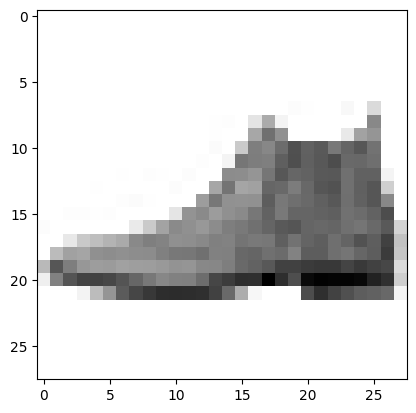

In [30]:
plt.imshow(X_test[0],cmap='binary')

In [20]:
np.round(model.predict(X_test_scaled[:1]),2)

1/1 [==============================] - 0s 379ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],
      dtype=float32)

In [32]:
np.round(y_probas[:,:1],2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.75, 0.  , 0.25]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.96]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.2 , 0.  , 0.8 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.96]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1

This  tells  a  very  different  story:  apparently,  when  we  activate  dropout,  the  model  is
not  sure  anymore.  It  still  seems  to  prefer  class  9,  but  sometimes  it  hesitates  with
classes 5 (sandal) and 7 (sneaker), which makes sense given they’re all footwear.

In [34]:
np.argmax(np.round(y_proba[:1],2))

9

let's take a look at the standard deviation of the standard deviation

In [35]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1],2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.21]],
      dtype=float32)

If your model contains other layers that behave in a special way during training (such
as BatchNormalization layers), then you should not force training mode like we just
did.  Instead,  you  should  replace  the  Dropout  layers  with  the  following  MCDropout class:
```python
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)
```

### <div style="font-family:fantasy;">max-norm regularization</div>
For each neuron this regularization technique constraints the weights $\mathbf{w}$ of the incoming connections such that the $\ell_2$ norm of weights i.e $||\mathbf{w}||_2\leq r$. Where $r$ is the max-norm hyperparameter.

Max-norm  regularization  does  not  add  a  regularization  loss  term  to  the  overall  loss
function.  Instead,  it  is  typically  implemented  by  computing  $∥\mathbf{w}∥_2$  after  each  training
step and rescaling w if needed $(\mathbf{w} ← \mathbf{w} \ r/ ||\mathbf{w}||_2)$.

Reducing r increases the amount of regularization and helps reduce overfitting. Max-
norm  regularization  can  also  help  alleviate  the  unstable  gradients  problems  (if  you
are not using Batch Normalization)

In [37]:
keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",kernel_constraint=keras.constraints.max_norm(1))

After  each  training  iteration,  the  model’s  `fit()`  method  will  call  the  object  returned
by  `max_norm()`,  passing  it  the  layer’s  weights  and  getting  rescaled  weights  in  return,
which  then  replace  the  layer’s  weights.

The max_norm() function has an axis argument that defaults to 0. A Dense layer usu‐
ally  has  weights  of  shape  [number  of  inputs,  number  of  neurons],  so  using  axis=0
means  that  the  max-norm  constraint  will  apply  independently  to  each  neuron’s
weight  vector.  If  you  want  to  use  max-norm  with  convolutional  layers,  make  sure  to  set  the  max_norm()  constraint’s  axis  argument  appropriately
(usually axis=[0, 1, 2]).

# <div style="font-family:fantasy;">Practical usage </div>


<img src="https://dsm04pap003files.storage.live.com/y4maW_t-Ncj_wmwVdBL0Ei665eYx_3x35pJTojuWUOv7GoFHKCIvWuo0M6BQnPzmD5ZFnTr378TGy3q0xAlp7F_2-Ifvmg8yIGOwM6mjU0Kn2WYjnXBN9XsdfiqUrOMmZYa5CgbiQqhBEG7Un0xMdAMxoPKIpaogjW-TKAG8zbkSNzlMcQrV6KV4GrfECRrMAn_?width=388&height=201&cropmode=none" width="388" height="201" />

the following image suggests the default values of the hyperparameters of the `model.compile` which are good to go.

though if  the  network  is  a  simple  stack  of  dense  layers,  then  it  can  self-normalize,  and  you
should use the configuration in the below table 

<img src="https://dsm04pap003files.storage.live.com/y4mfx157r4PqtD435SQ-6Fl5KrdoZ096PZxIDMlrgtjzPcLTnGqNp3z-_6-VBFJswBPeYlJwVNTij_sn4d1eQ4D1WrxYi5JK4natpK8zGRHIiaj8DeiuB3T8OEn5knb12Eli5DAAgxYzW5ntJdirLgVmjRhrkKXqHbgo1c-YjAkMpz9lM63WBr55Nj0UZ-gwaPf?width=389&height=198&cropmode=none" width="389" height="198" />

---
---
---
